#  настройка алгоритма

Автор: Никоноров Е.Н.
Дата: 24.11.2022
Курс: Аналитик данных (Data scientist) 2022
Кейс: №3 «Прогнозирование размеров сварного шва при электронно-лучевой сварке тонкостенных конструкций аэрокосмического назначения»

Искомые параметры: 
1.Width
2.Depth


Описание файла:
1. Загружаем данные из initail, merged, generated 
2. Формируем X, y 
3. Разделяем на обучающую и тестовую выборки
4. Поиск лучших параметров для выбранного метода
5. Де-нормирование
6. Сохранение модели для использования на практике

In [1]:
#импорт библиотек

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
#загрузка данных
df_merged = pd.read_excel("../Data/ds_merged.xlsx ")
df_merged = df_merged.drop(['Unnamed: 0'], axis =1)

df_initial = pd.read_excel("../Data/ds_initial.xlsx ")
df_initial = df_initial.drop(['Unnamed: 0'], axis =1)

df_initial_norm = pd.read_excel("../Data/ds_initial_norm.xlsx ")
df_initial_norm = df_initial_norm.drop(['Unnamed: 0'], axis =1)


df_generated = pd.read_excel("../Data/ds_generated.xlsx ")
df_generated = df_generated.drop(['Unnamed: 0'], axis =1)

In [3]:
#Входы и выходы для моделей
#менять датасет тут
df = df_initial

X=df.iloc[:,:4].to_numpy()
y=df.iloc[:,4:].to_numpy()


In [4]:
#Определение функции для визуализации
  
def save_result(y_train,y_train_pred, y_test, y_pred, model_name, ds):
    fig,axs = plt.subplots(figsize=(16,4), ncols=3)
    axs[0].scatter(y_train, y_train_pred)
    axs[0].set_title('train data')

    axs[1].scatter(y_pred, y_test, label="test data")
    axs[1].set_title('test data')
    err=y_pred - y_test
    axs[2].scatter(err[:,0], err[:,1], label="error")
    axs[2].set_title('error (test)')

    print('mse', mean_squared_error(y_test,y_pred))
    print('mae', mean_absolute_error(y_test,y_pred))
    print('Coef of determination (vec)', r2_score(y_test,y_pred))
    print('Coef of determination Depth', r2_score(y_test[:,0],y_pred[:,0]))
    print('Coef of determination Width', r2_score(y_test[:,1],y_pred[:,1]))
    
    
    plt.figure(figsize=(17,5))
    plt.title(f'Тестовые и прогнозные значения: {model_name}')
    plt.plot(y_test, label='Тест')
    plt.plot(y_pred, label='Прогноз')
    plt.legend(loc='best')
    plt.ylabel('W+D')
    plt.xlabel('Количество наблюдений')
    plt.show()
    
    
    MSE_depth = mean_squared_error(y_test[:,0], y_pred[:,0])
    R2_depth = r2_score(y_test[:,0],  y_pred[:,0])
    
    MSE_width = mean_squared_error(y_test[:,1], y_pred[:,1])
    R2_width = r2_score(y_test[:,1],  y_pred[:,1])

    linear_errors = pd.DataFrame({
        'model_name':model_name,
        'target_var':['Width', 'Depth'],
        'MSE':[MSE_width, MSE_depth],
        'R2':[R2_width, R2_depth]})
    ds = pd.concat([ds, linear_errors], ignore_index=True)
    return ds
    #reg.score(X_test, y_test)

    #((y_test-y_pred) ** 2).mean()

In [5]:
errors_df = pd.DataFrame(columns=['target_var','model_name','MSE','R2'])

In [6]:
from sklearn.neighbors import KNeighborsRegressor

In [7]:
output_df_width = df['Width']
output_df_depth = df['Depth']
input_df_width = df.loc[:, ~df.columns.isin(['Width','Depth'])]

input_df_depth = df.loc[:, ~df.columns.isin(['Width','Depth'])]

#Разделяем датасет на обучающую и тестовую выборки
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(input_df_width, output_df_width , test_size=0.3, random_state=42)
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(input_df_depth, output_df_depth, test_size=0.3, random_state=42)
df.shape[0] - X_train_w.shape[0] - X_test_w.shape[0]

X_train, X_test, y_train, y_test =  train_test_split(X, y , test_size=0.3, random_state=42)

In [8]:


#Регрессия k-ближайших соседей
knr_model = KNeighborsRegressor()
neigh_params = {'n_neighbors' : range(1, 10, 1),
'weights' : ['uniform', 'distance'],
'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']
}

GSCV_neigh = GridSearchCV(knr_model, neigh_params, n_jobs=-1, cv=5)
GSCV_neigh.fit(X_train, y_train)
neigh = GSCV_neigh.best_estimator_



In [9]:
#эффекта от раздельной регрессии нет

#GSCV_neigh_1 = GridSearchCV(knr_model, neigh_params, n_jobs=-1, cv=5)
#GSCV_neigh_1.fit(X_train_w, y_train_w)
#neigh_1 = GSCV_neigh_1.best_estimator_
#MSE_upr = mean_squared_error(y_test_w, neigh_1.predict(X_test_w))
#R2_w = r2_score(y_test_w, neigh_1.predict(X_test_w))

#GSCV_neigh_2 = GridSearchCV(knr_model, neigh_params, n_jobs=-1, cv=5)
#GSCV_neigh_2.fit(X_train_d, y_train_d)
#neigh_2 = GSCV_neigh_2.best_estimator_
#MSE_d = mean_squared_error(y_test_d, neigh_2.predict(X_test_d))
#R2_d = r2_score(y_test_d, neigh_2.predict(X_test_d))

# Результат

mse 0.004540909090909091
mae 0.053636363636363635
Coef of determination (vec) 0.9268764775310774
Coef of determination Depth 0.8794180598137329
Coef of determination Width 0.974334895248422


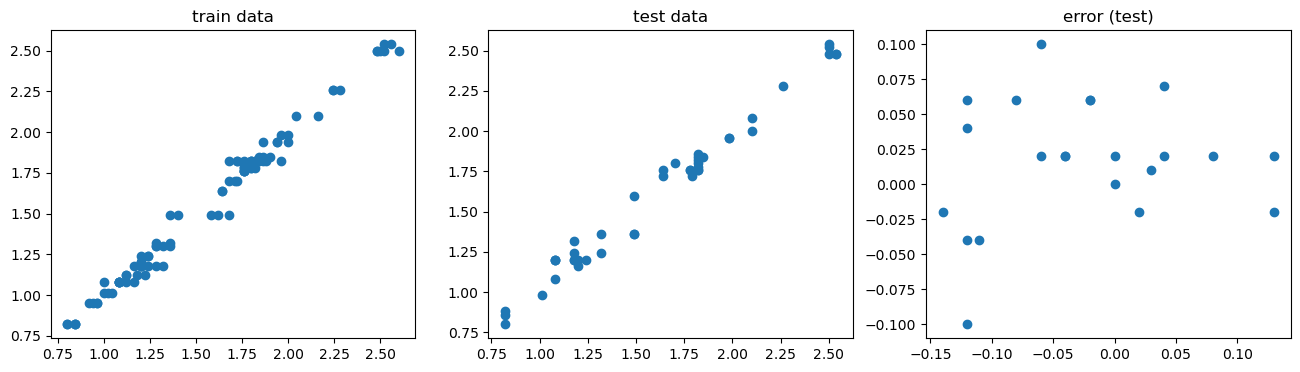

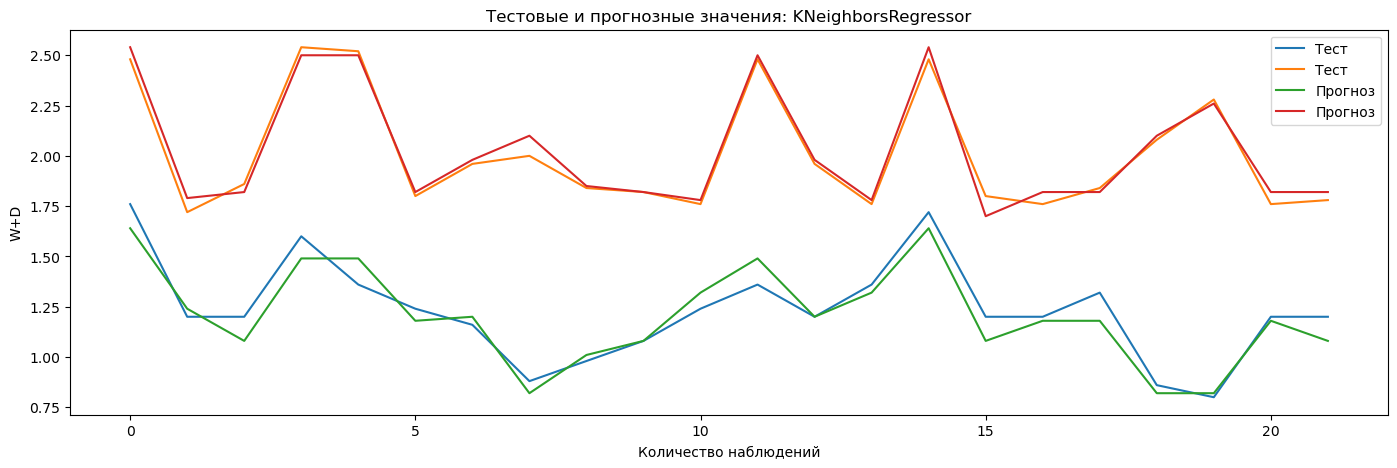

,target_var,model_name,MSE,R2
0,Width,KNeighborsRegressor,0.002191,0.974335
1,Depth,KNeighborsRegressor,0.006891,0.879418


In [10]:
y_train_pred = neigh.predict(X_train)
y_pred = neigh.predict(X_test)

final_model = neigh
errors_df = save_result(y_train,y_train_pred, y_test, y_pred, 'KNeighborsRegressor', errors_df)
errors_df

# Вывод

Изменение параметров алгоритма в широком диапазоне (несколько тысяч экспериментов) не позволили существенно увеличить качество алгоритма относительно параметров из документации.

Наибольший эффект на "качество" оказывает случайное разбиение на Train\Test и random_state

# Влияние Random на результат

In [11]:
scores = [0]
best_random = 0
best_model= 0
for x in range(1, 1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = x)
    neigh.fit(X_train, y_train)
    y_train_pred = neigh.predict(X_train)
    y_pred = neigh.predict(X_test)
    
    sumR2 = r2_score(y_test[:,0],y_pred[:,0])+r2_score(y_test[:,1],y_pred[:,1])
    
    if np.max(scores) < sumR2:
        best_random = x
        best_model = neigh
    scores.append(sumR2)
    
best_random

29

mse 0.0009166666666666672
mae 0.02233333333333333
Coef of determination (vec) 0.9865090411518369
Coef of determination Depth 0.9837073090249133
Coef of determination Width 0.9893107732787604


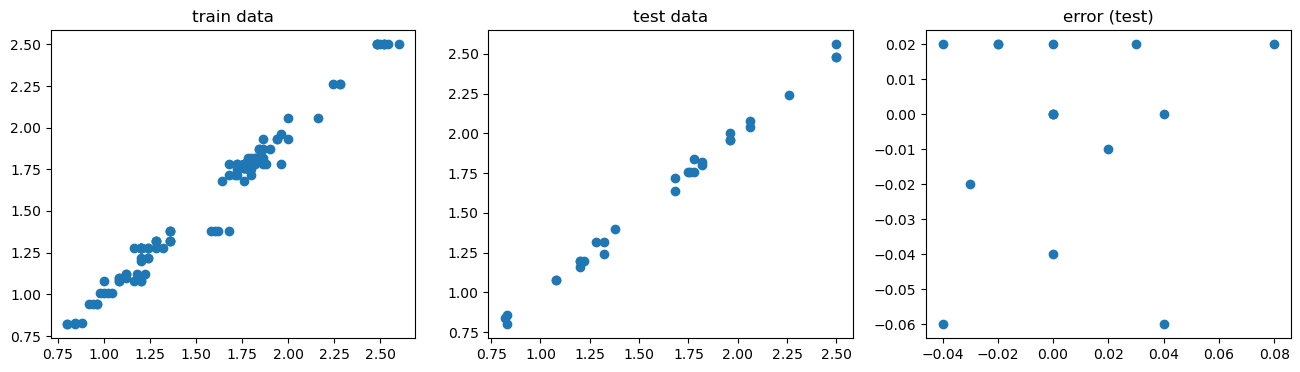

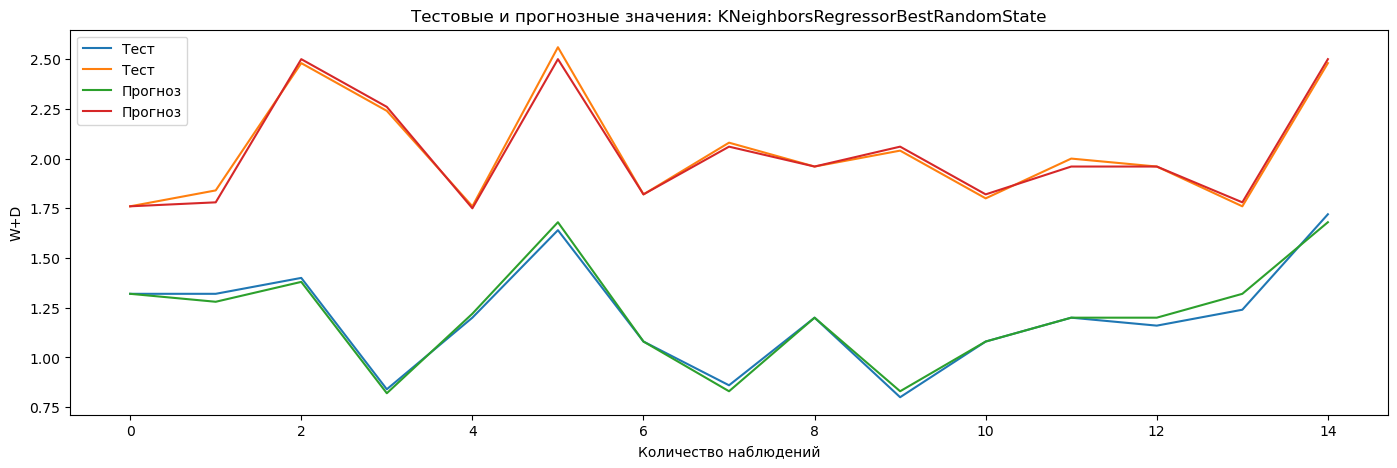

,target_var,model_name,MSE,R2
0,Width,KNeighborsRegressor,0.002191,0.974335
1,Depth,KNeighborsRegressor,0.006891,0.879418
2,Width,KNeighborsRegressorBestRandomState,0.000780,0.989311
3,Depth,KNeighborsRegressorBestRandomState,0.001053,0.983707


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = best_random)

y_train_pred = best_model.predict(X_train)
y_pred = best_model.predict(X_test)

errors_df = save_result(y_train,y_train_pred, y_test, y_pred, 'KNeighborsRegressorBestRandomState', errors_df)
errors_df

In [13]:
scores = [2]
worst_r2 = 0
worst_random= 0
for x in range(1, 1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = x)

    y_train_pred = best_model.predict(X_train)
    y_pred = best_model.predict(X_test)
    
    sumR2 = r2_score(y_test[:,0],y_pred[:,0])+r2_score(y_test[:,1],y_pred[:,1])
    
    if np.max(scores) > sumR2:
        worst_r2 = sumR2
        worst_random = x
    scores.append(sumR2)
    
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = worst_random)
y_train_pred = best_model.predict(X_train)
y_pred = best_model.predict(X_test)
print('W',r2_score(y_test[:,0],y_pred[:,0]))
print('D',r2_score(y_test[:,1],y_pred[:,1]))

W 0.7102885873119684
D 0.9726116394563293


# Сохранение модели
сохраняем в папку Saved models

In [20]:
import pickle

In [21]:
with open('../Saved models/rf_model_pkl.pkl', 'wb') as f:
    pickle.dump(final_model,f)

In [22]:
!pip freeze > requirements.txt

In [23]:
import joblib


In [24]:
joblib.dump(final_model, '../Saved models/rf_model_jl.jl')

['../Saved models/rf_model_jl.jl']

In [26]:
joblib.dump(final_model, '../4.App/rf_model_jl.jl')

['../4.App/rf_model_jl.jl']